# This project for classifying dirty Dishes and cleaned Dishes 


In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/platesv2/sample_submission.csv
/kaggle/input/platesv2/plates.zip


In [2]:
# order libraries
import torch 
import numpy as np 
import matplotlib.pyplot as plt 
import time 
import copy 
import zipfile 
import shutil 
from tqdm import tqdm 
from torchvision import transforms , models 
import torchvision

# 1.Photo modification

In [3]:
# Unzip photos
with zipfile.ZipFile('../input/platesv2/plates.zip','r')as file: 
    file.extractall('/kaggle/working') 

In [4]:
data = '/kaggle/working/plates/' 
print(os.listdir(data))

['test', '.DS_Store', 'train']


In [5]:
# chapter about different types of photos Dishes

train_uncl = 'train' 
val_uncl = 'val' 

type_names = ['cleaned','dirty'] 

for uncl_name in [train_uncl , val_uncl]:
    for type_name in type_names:
        os.makedirs(os.path.join(uncl_name , type_name),exist_ok =True) 

for type_name in type_names:
    source_uncl = os.path.join(data,'train',type_name) 
    for i , infor_name in enumerate(tqdm(os.listdir(source_uncl))):
        if i % 6 != 0:
            dest_uncl = os.path.join(train_uncl , type_name) 
        else:
            dest_uncl = os.path.join(val_uncl , type_name) 
        shutil.copy(os.path.join(source_uncl , infor_name),os.path.join(dest_uncl , infor_name))

100%|██████████| 21/21 [00:00<00:00, 4804.47it/s]


# 2.building Torch's model for size photos

In [6]:
train_trans= transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225]) 
    
])
val_trans = transforms.Compose([
    transforms.Resize((244,244)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])



train_dataset = torchvision.datasets.ImageFolder(train_uncl , train_trans) 
val_dataset = torchvision.datasets.ImageFolder(val_uncl,val_trans) 

batch_size = 8 

train_dataloader = torch.utils.data.DataLoader(
    train_dataset , batch_size = batch_size , shuffle = True  , num_workers = batch_size) 

val_dataloader = torch.utils.data.DataLoader(val_dataset , batch_size = batch_size , shuffle = False , num_workers = batch_size) 





/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [7]:
len(train_dataloader), len(train_dataset)

(4, 32)

# 3.Drawing pictures

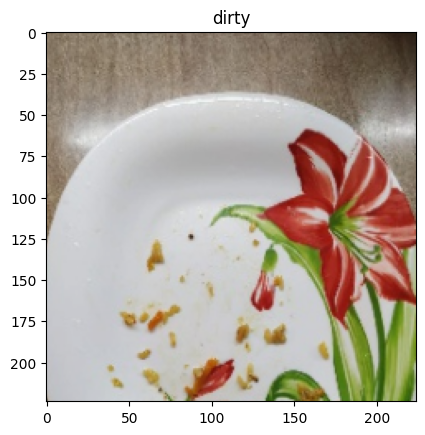

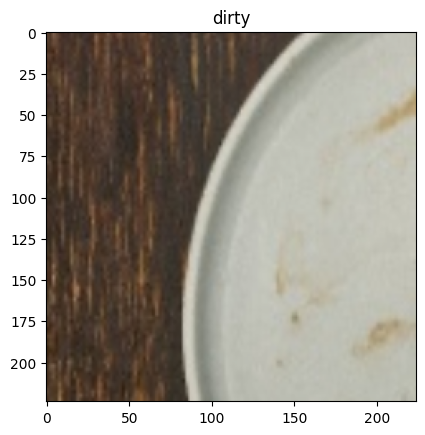

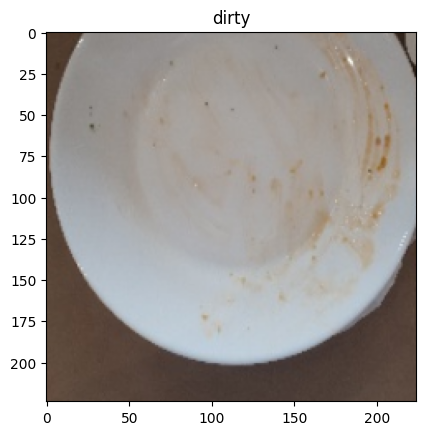

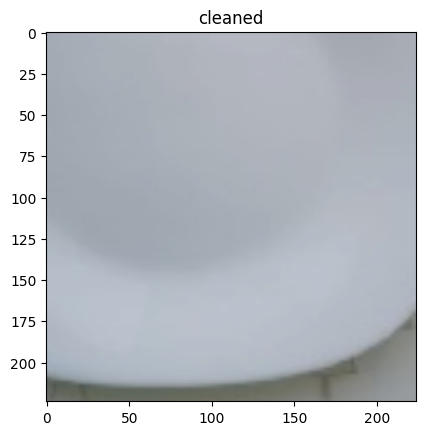

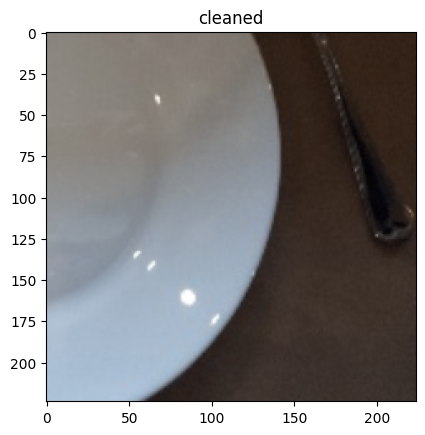

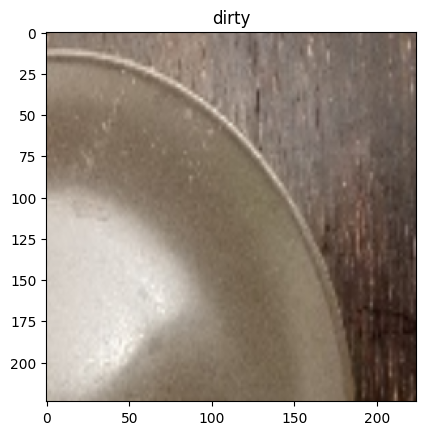

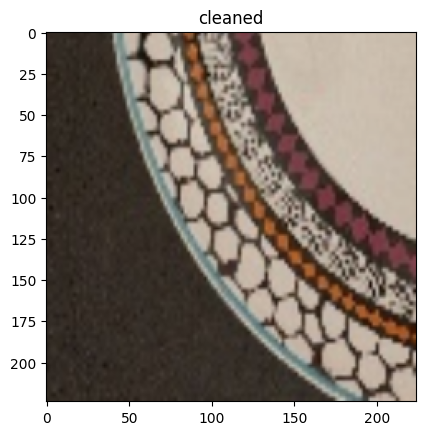

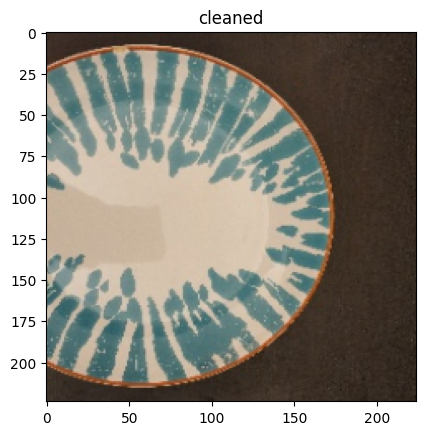

In [8]:
def input_photos(input_tensor , title = ''):
    
    image = input_tensor.permute(1,2,0).numpy() 
    image = std * image + mean 
    plt.imshow(image.clip(0,1))
    plt.title(title)
    plt.show() 
    plt.pause(0.001) 

X_batch , y_batch = next(iter(train_dataloader)) 
mean = np.array([0.485 , 0.456 , 0.406]) 
std = np.array([0.229 , 0.224,0.225]) 


for x_item , y_item in zip(X_batch , y_batch):
    input_photos(x_item , title = type_names[y_item])

# 4. PyTorch model

In [9]:
def train_model(model , loss , optimizer , rules , num_epochs):
    for epoch in range(num_epochs):
        print('Epoch {}/{}:'.format(epoch , num_epochs - 1), flush = True)


        for x in ['train','val']:
            if x == 'train':
                dataloader = train_dataloader
                rules.step() 
                model.train() 
            else:
                dataloader = val_dataloader
                model.eval() 

            running_loss = 0.
            running_acc = 0. 

            for inputs , labels in tqdm(dataloader):
                inputs = inputs.to(device) 
                labels = labels.to(device) 

                optimizer.zero_grad() 

                with torch.set_grad_enabled(x == 'train'):
                    preds = model(inputs) 
                    loss_value = loss(preds , labels) 
                    preds_class = preds.argmax(dim =1) 

                if x == 'train':
                    loss_value.backward() 
                    optimizer.step() 


                
                running_loss += loss_value.item() 
                running_acc += (preds_class == labels.data).float().mean() 


            epoch_loss  = running_loss / len(dataloader) 
            epoch_acc = running_acc / len(dataloader) 

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(x , epoch_loss,epoch_acc),flush = True) 

    return model

# 5. prediciting PyTorch

In [10]:
model = models.resnet18(pretrained = True) 

for y in model.parameters():
    y.requires_grad = False 

model.fc = torch.nn.Linear(model.fc.in_features , 2) 

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = model.to(device) 

loss = torch.nn.CrossEntropyLoss() 
optimizer = torch.optim.Adam(model.parameters(), lr = 1.0e-3)

rules = torch.optim.lr_scheduler.StepLR(optimizer , step_size = 4 , gamma = 0.1)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 146MB/s]


In [11]:
train_model(model , loss ,optimizer , rules , num_epochs = 100 );

Epoch 0/99:


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:227: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(
100%|██████████| 4/4 [00:02<00:00,  1.93it/s]

train Loss: 0.8734 Acc: 0.2188



100%|██████████| 1/1 [00:00<00:00,  1.18it/s]

val Loss: 0.5802 Acc: 0.7500
Epoch 1/99:



100%|██████████| 4/4 [00:01<00:00,  2.13it/s]

train Loss: 0.6439 Acc: 0.6875



100%|██████████| 1/1 [00:00<00:00,  1.18it/s]

val Loss: 0.5735 Acc: 0.7500
Epoch 2/99:



100%|██████████| 4/4 [00:02<00:00,  1.95it/s]

train Loss: 0.6719 Acc: 0.5625



100%|██████████| 1/1 [00:00<00:00,  1.10it/s]

val Loss: 0.5604 Acc: 0.7500
Epoch 3/99:



100%|██████████| 4/4 [00:01<00:00,  2.08it/s]

train Loss: 0.6203 Acc: 0.6875



100%|██████████| 1/1 [00:00<00:00,  1.17it/s]

val Loss: 0.5652 Acc: 0.7500
Epoch 4/99:



100%|██████████| 4/4 [00:01<00:00,  2.06it/s]

train Loss: 0.6291 Acc: 0.5938



100%|██████████| 1/1 [00:00<00:00,  1.15it/s]

val Loss: 0.5634 Acc: 0.7500
Epoch 5/99:



100%|██████████| 4/4 [00:01<00:00,  2.02it/s]

train Loss: 0.6533 Acc: 0.5938



100%|██████████| 1/1 [00:00<00:00,  1.09it/s]

val Loss: 0.5670 Acc: 0.7500
Epoch 6/99:



100%|██████████| 4/4 [00:02<00:00,  1.97it/s]

train Loss: 0.5956 Acc: 0.7188



100%|██████████| 1/1 [00:00<00:00,  1.13it/s]

val Loss: 0.5636 Acc: 0.7500
Epoch 7/99:



100%|██████████| 4/4 [00:01<00:00,  2.09it/s]

train Loss: 0.6230 Acc: 0.6562



100%|██████████| 1/1 [00:00<00:00,  1.10it/s]

val Loss: 0.5760 Acc: 0.7500
Epoch 8/99:



100%|██████████| 4/4 [00:01<00:00,  2.05it/s]

train Loss: 0.6137 Acc: 0.6875



100%|██████████| 1/1 [00:00<00:00,  1.10it/s]

val Loss: 0.5692 Acc: 0.7500
Epoch 9/99:



100%|██████████| 4/4 [00:02<00:00,  1.92it/s]

train Loss: 0.6383 Acc: 0.6562



100%|██████████| 1/1 [00:00<00:00,  1.11it/s]

val Loss: 0.5754 Acc: 0.7500
Epoch 10/99:



100%|██████████| 4/4 [00:01<00:00,  2.08it/s]

train Loss: 0.5523 Acc: 0.7500



100%|██████████| 1/1 [00:00<00:00,  1.14it/s]

val Loss: 0.5803 Acc: 0.7500
Epoch 11/99:



100%|██████████| 4/4 [00:01<00:00,  2.03it/s]

train Loss: 0.5811 Acc: 0.6875



100%|██████████| 1/1 [00:00<00:00,  1.18it/s]

val Loss: 0.5793 Acc: 0.7500
Epoch 12/99:



100%|██████████| 4/4 [00:01<00:00,  2.10it/s]

train Loss: 0.6213 Acc: 0.6562



100%|██████████| 1/1 [00:00<00:00,  1.14it/s]

val Loss: 0.5822 Acc: 0.7500
Epoch 13/99:



100%|██████████| 4/4 [00:01<00:00,  2.02it/s]

train Loss: 0.5415 Acc: 0.7500



100%|██████████| 1/1 [00:00<00:00,  1.13it/s]

val Loss: 0.5778 Acc: 0.7500
Epoch 14/99:



100%|██████████| 4/4 [00:01<00:00,  2.11it/s]

train Loss: 0.5269 Acc: 0.8125



100%|██████████| 1/1 [00:00<00:00,  1.17it/s]

val Loss: 0.5767 Acc: 0.7500
Epoch 15/99:



100%|██████████| 4/4 [00:01<00:00,  2.11it/s]

train Loss: 0.6174 Acc: 0.6562



100%|██████████| 1/1 [00:00<00:00,  1.17it/s]

val Loss: 0.5774 Acc: 0.7500
Epoch 16/99:



100%|██████████| 4/4 [00:02<00:00,  1.97it/s]

train Loss: 0.6119 Acc: 0.7188



100%|██████████| 1/1 [00:00<00:00,  1.12it/s]

val Loss: 0.5838 Acc: 0.7500
Epoch 17/99:



100%|██████████| 4/4 [00:01<00:00,  2.10it/s]

train Loss: 0.6793 Acc: 0.5625



100%|██████████| 1/1 [00:00<00:00,  1.17it/s]

val Loss: 0.5813 Acc: 0.7500
Epoch 18/99:



100%|██████████| 4/4 [00:01<00:00,  2.12it/s]

train Loss: 0.5817 Acc: 0.7812



100%|██████████| 1/1 [00:00<00:00,  1.16it/s]

val Loss: 0.5903 Acc: 0.7500
Epoch 19/99:



100%|██████████| 4/4 [00:01<00:00,  2.07it/s]

train Loss: 0.6407 Acc: 0.5000



100%|██████████| 1/1 [00:00<00:00,  1.17it/s]

val Loss: 0.5821 Acc: 0.7500
Epoch 20/99:



100%|██████████| 4/4 [00:02<00:00,  1.89it/s]

train Loss: 0.6175 Acc: 0.6562



100%|██████████| 1/1 [00:00<00:00,  1.18it/s]

val Loss: 0.5816 Acc: 0.7500
Epoch 21/99:



100%|██████████| 4/4 [00:01<00:00,  2.05it/s]

train Loss: 0.6357 Acc: 0.5312



100%|██████████| 1/1 [00:00<00:00,  1.15it/s]

val Loss: 0.5742 Acc: 0.7500
Epoch 22/99:



100%|██████████| 4/4 [00:01<00:00,  2.14it/s]

train Loss: 0.6574 Acc: 0.5625



100%|██████████| 1/1 [00:00<00:00,  1.17it/s]

val Loss: 0.5712 Acc: 0.6250
Epoch 23/99:



100%|██████████| 4/4 [00:01<00:00,  2.05it/s]

train Loss: 0.6095 Acc: 0.5625



100%|██████████| 1/1 [00:00<00:00,  1.05it/s]

val Loss: 0.5783 Acc: 0.6250
Epoch 24/99:



100%|██████████| 4/4 [00:01<00:00,  2.11it/s]

train Loss: 0.6022 Acc: 0.6250



100%|██████████| 1/1 [00:00<00:00,  1.18it/s]

val Loss: 0.5705 Acc: 0.7500
Epoch 25/99:



100%|██████████| 4/4 [00:01<00:00,  2.11it/s]

train Loss: 0.5746 Acc: 0.7188



100%|██████████| 1/1 [00:00<00:00,  1.17it/s]

val Loss: 0.5707 Acc: 0.7500
Epoch 26/99:



100%|██████████| 4/4 [00:01<00:00,  2.13it/s]

train Loss: 0.6308 Acc: 0.7188



100%|██████████| 1/1 [00:00<00:00,  1.16it/s]

val Loss: 0.5682 Acc: 0.7500
Epoch 27/99:



100%|██████████| 4/4 [00:02<00:00,  1.85it/s]

train Loss: 0.5656 Acc: 0.7500



100%|██████████| 1/1 [00:00<00:00,  1.19it/s]

val Loss: 0.5680 Acc: 0.7500
Epoch 28/99:



100%|██████████| 4/4 [00:01<00:00,  2.13it/s]

train Loss: 0.5538 Acc: 0.7500



100%|██████████| 1/1 [00:00<00:00,  1.17it/s]

val Loss: 0.5721 Acc: 0.7500
Epoch 29/99:



100%|██████████| 4/4 [00:01<00:00,  2.10it/s]

train Loss: 0.6220 Acc: 0.7188



100%|██████████| 1/1 [00:00<00:00,  1.16it/s]

val Loss: 0.5798 Acc: 0.7500
Epoch 30/99:



100%|██████████| 4/4 [00:01<00:00,  2.08it/s]

train Loss: 0.6248 Acc: 0.5938



100%|██████████| 1/1 [00:01<00:00,  1.00s/it]

val Loss: 0.5807 Acc: 0.7500
Epoch 31/99:



100%|██████████| 4/4 [00:01<00:00,  2.12it/s]

train Loss: 0.5502 Acc: 0.7188



100%|██████████| 1/1 [00:00<00:00,  1.17it/s]

val Loss: 0.5803 Acc: 0.7500
Epoch 32/99:



100%|██████████| 4/4 [00:01<00:00,  2.12it/s]

train Loss: 0.5980 Acc: 0.6875



100%|██████████| 1/1 [00:00<00:00,  1.18it/s]

val Loss: 0.5796 Acc: 0.7500
Epoch 33/99:



100%|██████████| 4/4 [00:01<00:00,  2.14it/s]

train Loss: 0.5459 Acc: 0.7500



100%|██████████| 1/1 [00:00<00:00,  1.17it/s]

val Loss: 0.5722 Acc: 0.7500
Epoch 34/99:



100%|██████████| 4/4 [00:02<00:00,  1.86it/s]

train Loss: 0.6065 Acc: 0.6562



100%|██████████| 1/1 [00:00<00:00,  1.17it/s]

val Loss: 0.5711 Acc: 0.7500
Epoch 35/99:



100%|██████████| 4/4 [00:01<00:00,  2.07it/s]

train Loss: 0.5785 Acc: 0.8438



100%|██████████| 1/1 [00:00<00:00,  1.16it/s]

val Loss: 0.5713 Acc: 0.7500
Epoch 36/99:



100%|██████████| 4/4 [00:01<00:00,  2.12it/s]

train Loss: 0.5992 Acc: 0.7188



100%|██████████| 1/1 [00:00<00:00,  1.19it/s]

val Loss: 0.5793 Acc: 0.7500
Epoch 37/99:



100%|██████████| 4/4 [00:01<00:00,  2.12it/s]

train Loss: 0.6468 Acc: 0.6250



100%|██████████| 1/1 [00:00<00:00,  1.01it/s]

val Loss: 0.5707 Acc: 0.7500
Epoch 38/99:



100%|██████████| 4/4 [00:01<00:00,  2.05it/s]

train Loss: 0.6071 Acc: 0.6875



100%|██████████| 1/1 [00:00<00:00,  1.18it/s]

val Loss: 0.5691 Acc: 0.7500
Epoch 39/99:



100%|██████████| 4/4 [00:01<00:00,  2.12it/s]

train Loss: 0.6193 Acc: 0.6250



100%|██████████| 1/1 [00:00<00:00,  1.17it/s]

val Loss: 0.5695 Acc: 0.7500
Epoch 40/99:



100%|██████████| 4/4 [00:01<00:00,  2.11it/s]

train Loss: 0.5607 Acc: 0.7812



100%|██████████| 1/1 [00:00<00:00,  1.17it/s]

val Loss: 0.5657 Acc: 0.7500
Epoch 41/99:



100%|██████████| 4/4 [00:02<00:00,  1.93it/s]

train Loss: 0.6072 Acc: 0.6875



100%|██████████| 1/1 [00:00<00:00,  1.16it/s]

val Loss: 0.5646 Acc: 0.7500
Epoch 42/99:



100%|██████████| 4/4 [00:01<00:00,  2.06it/s]

train Loss: 0.5818 Acc: 0.7188



100%|██████████| 1/1 [00:00<00:00,  1.16it/s]

val Loss: 0.5703 Acc: 0.7500
Epoch 43/99:



100%|██████████| 4/4 [00:01<00:00,  2.07it/s]

train Loss: 0.6200 Acc: 0.7500



100%|██████████| 1/1 [00:00<00:00,  1.21it/s]

val Loss: 0.5703 Acc: 0.7500
Epoch 44/99:



100%|██████████| 4/4 [00:01<00:00,  2.10it/s]

train Loss: 0.5718 Acc: 0.7812



100%|██████████| 1/1 [00:00<00:00,  1.06it/s]

val Loss: 0.5728 Acc: 0.6250
Epoch 45/99:



100%|██████████| 4/4 [00:02<00:00,  1.99it/s]

train Loss: 0.5664 Acc: 0.8438



100%|██████████| 1/1 [00:00<00:00,  1.13it/s]

val Loss: 0.5708 Acc: 0.7500
Epoch 46/99:



100%|██████████| 4/4 [00:01<00:00,  2.08it/s]

train Loss: 0.6135 Acc: 0.7500



100%|██████████| 1/1 [00:00<00:00,  1.16it/s]

val Loss: 0.5730 Acc: 0.7500
Epoch 47/99:



100%|██████████| 4/4 [00:01<00:00,  2.09it/s]

train Loss: 0.5526 Acc: 0.7812



100%|██████████| 1/1 [00:00<00:00,  1.15it/s]

val Loss: 0.5757 Acc: 0.7500
Epoch 48/99:



100%|██████████| 4/4 [00:02<00:00,  1.86it/s]

train Loss: 0.6296 Acc: 0.7812



100%|██████████| 1/1 [00:00<00:00,  1.17it/s]

val Loss: 0.5601 Acc: 0.7500
Epoch 49/99:



100%|██████████| 4/4 [00:01<00:00,  2.14it/s]

train Loss: 0.6122 Acc: 0.6250



100%|██████████| 1/1 [00:00<00:00,  1.18it/s]

val Loss: 0.5744 Acc: 0.7500
Epoch 50/99:



100%|██████████| 4/4 [00:01<00:00,  2.14it/s]

train Loss: 0.6272 Acc: 0.6250



100%|██████████| 1/1 [00:00<00:00,  1.19it/s]

val Loss: 0.5697 Acc: 0.7500
Epoch 51/99:



100%|██████████| 4/4 [00:01<00:00,  2.12it/s]

train Loss: 0.6544 Acc: 0.5000



100%|██████████| 1/1 [00:00<00:00,  1.17it/s]

val Loss: 0.5762 Acc: 0.7500
Epoch 52/99:



100%|██████████| 4/4 [00:01<00:00,  2.08it/s]

train Loss: 0.5692 Acc: 0.7188



100%|██████████| 1/1 [00:00<00:00,  1.21it/s]

val Loss: 0.5737 Acc: 0.7500
Epoch 53/99:



100%|██████████| 4/4 [00:01<00:00,  2.04it/s]

train Loss: 0.6395 Acc: 0.5938



100%|██████████| 1/1 [00:00<00:00,  1.17it/s]

val Loss: 0.5748 Acc: 0.6250
Epoch 54/99:



100%|██████████| 4/4 [00:01<00:00,  2.14it/s]

train Loss: 0.6375 Acc: 0.6250



100%|██████████| 1/1 [00:00<00:00,  1.19it/s]

val Loss: 0.5785 Acc: 0.7500
Epoch 55/99:



100%|██████████| 4/4 [00:01<00:00,  2.03it/s]

train Loss: 0.5372 Acc: 0.8438



100%|██████████| 1/1 [00:00<00:00,  1.17it/s]

val Loss: 0.5735 Acc: 0.7500
Epoch 56/99:



100%|██████████| 4/4 [00:01<00:00,  2.14it/s]

train Loss: 0.6372 Acc: 0.5312



100%|██████████| 1/1 [00:00<00:00,  1.17it/s]

val Loss: 0.5705 Acc: 0.7500
Epoch 57/99:



100%|██████████| 4/4 [00:01<00:00,  2.11it/s]

train Loss: 0.5994 Acc: 0.6562



100%|██████████| 1/1 [00:00<00:00,  1.18it/s]

val Loss: 0.5755 Acc: 0.7500
Epoch 58/99:



100%|██████████| 4/4 [00:01<00:00,  2.11it/s]

train Loss: 0.6389 Acc: 0.5938



100%|██████████| 1/1 [00:00<00:00,  1.17it/s]

val Loss: 0.5767 Acc: 0.7500
Epoch 59/99:



100%|██████████| 4/4 [00:01<00:00,  2.03it/s]

train Loss: 0.6287 Acc: 0.6250



100%|██████████| 1/1 [00:00<00:00,  1.18it/s]

val Loss: 0.5797 Acc: 0.7500
Epoch 60/99:



100%|██████████| 4/4 [00:01<00:00,  2.09it/s]

train Loss: 0.6077 Acc: 0.6562



100%|██████████| 1/1 [00:00<00:00,  1.17it/s]

val Loss: 0.5732 Acc: 0.7500
Epoch 61/99:



100%|██████████| 4/4 [00:01<00:00,  2.08it/s]

train Loss: 0.5780 Acc: 0.7188



100%|██████████| 1/1 [00:00<00:00,  1.10it/s]

val Loss: 0.5721 Acc: 0.7500
Epoch 62/99:



100%|██████████| 4/4 [00:01<00:00,  2.09it/s]

train Loss: 0.6475 Acc: 0.7188



100%|██████████| 1/1 [00:00<00:00,  1.15it/s]

val Loss: 0.5706 Acc: 0.7500
Epoch 63/99:



100%|██████████| 4/4 [00:01<00:00,  2.12it/s]

train Loss: 0.6610 Acc: 0.6250



100%|██████████| 1/1 [00:00<00:00,  1.16it/s]

val Loss: 0.5733 Acc: 0.7500
Epoch 64/99:



100%|██████████| 4/4 [00:01<00:00,  2.07it/s]

train Loss: 0.6189 Acc: 0.5312



100%|██████████| 1/1 [00:00<00:00,  1.19it/s]

val Loss: 0.5717 Acc: 0.7500
Epoch 65/99:



100%|██████████| 4/4 [00:01<00:00,  2.13it/s]

train Loss: 0.6444 Acc: 0.6562



100%|██████████| 1/1 [00:00<00:00,  1.18it/s]

val Loss: 0.5729 Acc: 0.7500
Epoch 66/99:



100%|██████████| 4/4 [00:01<00:00,  2.06it/s]

train Loss: 0.6277 Acc: 0.6562



100%|██████████| 1/1 [00:00<00:00,  1.19it/s]

val Loss: 0.5717 Acc: 0.7500
Epoch 67/99:



100%|██████████| 4/4 [00:01<00:00,  2.10it/s]

train Loss: 0.5978 Acc: 0.6562



100%|██████████| 1/1 [00:00<00:00,  1.17it/s]

val Loss: 0.5717 Acc: 0.7500
Epoch 68/99:



100%|██████████| 4/4 [00:01<00:00,  2.11it/s]

train Loss: 0.5824 Acc: 0.6250



100%|██████████| 1/1 [00:00<00:00,  1.19it/s]

val Loss: 0.5701 Acc: 0.7500
Epoch 69/99:



100%|██████████| 4/4 [00:01<00:00,  2.13it/s]

train Loss: 0.6026 Acc: 0.6875



100%|██████████| 1/1 [00:00<00:00,  1.16it/s]

val Loss: 0.5681 Acc: 0.7500
Epoch 70/99:



100%|██████████| 4/4 [00:01<00:00,  2.06it/s]

train Loss: 0.6346 Acc: 0.6875



100%|██████████| 1/1 [00:00<00:00,  1.18it/s]

val Loss: 0.5691 Acc: 0.7500
Epoch 71/99:



100%|██████████| 4/4 [00:01<00:00,  2.12it/s]

train Loss: 0.6035 Acc: 0.6562



100%|██████████| 1/1 [00:00<00:00,  1.18it/s]

val Loss: 0.5712 Acc: 0.7500
Epoch 72/99:



100%|██████████| 4/4 [00:01<00:00,  2.12it/s]

train Loss: 0.6064 Acc: 0.6562



100%|██████████| 1/1 [00:00<00:00,  1.14it/s]

val Loss: 0.5727 Acc: 0.7500
Epoch 73/99:



100%|██████████| 4/4 [00:01<00:00,  2.03it/s]

train Loss: 0.5921 Acc: 0.6562



100%|██████████| 1/1 [00:00<00:00,  1.17it/s]

val Loss: 0.5742 Acc: 0.7500
Epoch 74/99:



100%|██████████| 4/4 [00:01<00:00,  2.11it/s]

train Loss: 0.5691 Acc: 0.6875



100%|██████████| 1/1 [00:00<00:00,  1.17it/s]

val Loss: 0.5745 Acc: 0.7500
Epoch 75/99:



100%|██████████| 4/4 [00:01<00:00,  2.05it/s]

train Loss: 0.6251 Acc: 0.6562



100%|██████████| 1/1 [00:00<00:00,  1.18it/s]

val Loss: 0.5658 Acc: 0.7500
Epoch 76/99:



100%|██████████| 4/4 [00:01<00:00,  2.14it/s]

train Loss: 0.6318 Acc: 0.6875



100%|██████████| 1/1 [00:00<00:00,  1.19it/s]

val Loss: 0.5701 Acc: 0.7500
Epoch 77/99:



100%|██████████| 4/4 [00:01<00:00,  2.08it/s]

train Loss: 0.5929 Acc: 0.7188



100%|██████████| 1/1 [00:00<00:00,  1.18it/s]

val Loss: 0.5791 Acc: 0.7500
Epoch 78/99:



100%|██████████| 4/4 [00:01<00:00,  2.10it/s]

train Loss: 0.6360 Acc: 0.6562



100%|██████████| 1/1 [00:00<00:00,  1.18it/s]

val Loss: 0.5737 Acc: 0.7500
Epoch 79/99:



100%|██████████| 4/4 [00:01<00:00,  2.12it/s]

train Loss: 0.6208 Acc: 0.6875



100%|██████████| 1/1 [00:00<00:00,  1.18it/s]

val Loss: 0.5820 Acc: 0.7500
Epoch 80/99:



100%|██████████| 4/4 [00:01<00:00,  2.11it/s]

train Loss: 0.6014 Acc: 0.7188



100%|██████████| 1/1 [00:00<00:00,  1.09it/s]

val Loss: 0.5834 Acc: 0.7500
Epoch 81/99:



100%|██████████| 4/4 [00:01<00:00,  2.13it/s]

train Loss: 0.6084 Acc: 0.7188



100%|██████████| 1/1 [00:00<00:00,  1.15it/s]

val Loss: 0.5818 Acc: 0.7500
Epoch 82/99:



100%|██████████| 4/4 [00:01<00:00,  2.06it/s]

train Loss: 0.5277 Acc: 0.7500



100%|██████████| 1/1 [00:00<00:00,  1.14it/s]

val Loss: 0.5739 Acc: 0.7500
Epoch 83/99:



100%|██████████| 4/4 [00:01<00:00,  2.07it/s]

train Loss: 0.6150 Acc: 0.5938



100%|██████████| 1/1 [00:00<00:00,  1.16it/s]

val Loss: 0.5638 Acc: 0.7500
Epoch 84/99:



100%|██████████| 4/4 [00:01<00:00,  2.04it/s]

train Loss: 0.5943 Acc: 0.6562



100%|██████████| 1/1 [00:00<00:00,  1.15it/s]

val Loss: 0.5632 Acc: 0.7500
Epoch 85/99:



100%|██████████| 4/4 [00:01<00:00,  2.08it/s]

train Loss: 0.6273 Acc: 0.5938



100%|██████████| 1/1 [00:00<00:00,  1.14it/s]

val Loss: 0.5754 Acc: 0.7500
Epoch 86/99:



100%|██████████| 4/4 [00:01<00:00,  2.02it/s]

train Loss: 0.6526 Acc: 0.6562



100%|██████████| 1/1 [00:00<00:00,  1.17it/s]

val Loss: 0.5706 Acc: 0.7500
Epoch 87/99:



100%|██████████| 4/4 [00:01<00:00,  2.09it/s]

train Loss: 0.5652 Acc: 0.8125



100%|██████████| 1/1 [00:00<00:00,  1.10it/s]

val Loss: 0.5691 Acc: 0.7500
Epoch 88/99:



100%|██████████| 4/4 [00:01<00:00,  2.09it/s]

train Loss: 0.5912 Acc: 0.6562



100%|██████████| 1/1 [00:00<00:00,  1.16it/s]

val Loss: 0.5698 Acc: 0.7500
Epoch 89/99:



100%|██████████| 4/4 [00:01<00:00,  2.12it/s]

train Loss: 0.6350 Acc: 0.6250



100%|██████████| 1/1 [00:00<00:00,  1.18it/s]

val Loss: 0.5738 Acc: 0.7500
Epoch 90/99:



100%|██████████| 4/4 [00:01<00:00,  2.10it/s]

train Loss: 0.6247 Acc: 0.6250



100%|██████████| 1/1 [00:00<00:00,  1.16it/s]

val Loss: 0.5769 Acc: 0.7500
Epoch 91/99:



100%|██████████| 4/4 [00:02<00:00,  1.98it/s]

train Loss: 0.6407 Acc: 0.5938



100%|██████████| 1/1 [00:00<00:00,  1.14it/s]

val Loss: 0.5755 Acc: 0.7500
Epoch 92/99:



100%|██████████| 4/4 [00:01<00:00,  2.13it/s]

train Loss: 0.6761 Acc: 0.5938



100%|██████████| 1/1 [00:00<00:00,  1.16it/s]

val Loss: 0.5697 Acc: 0.7500
Epoch 93/99:



100%|██████████| 4/4 [00:01<00:00,  2.11it/s]

train Loss: 0.5919 Acc: 0.6875



100%|██████████| 1/1 [00:00<00:00,  1.15it/s]

val Loss: 0.5632 Acc: 0.7500
Epoch 94/99:



100%|██████████| 4/4 [00:01<00:00,  2.08it/s]

train Loss: 0.5807 Acc: 0.7500



100%|██████████| 1/1 [00:00<00:00,  1.16it/s]

val Loss: 0.5713 Acc: 0.7500
Epoch 95/99:



100%|██████████| 4/4 [00:01<00:00,  2.06it/s]

train Loss: 0.6399 Acc: 0.7500



100%|██████████| 1/1 [00:00<00:00,  1.13it/s]

val Loss: 0.5701 Acc: 0.7500
Epoch 96/99:



100%|██████████| 4/4 [00:01<00:00,  2.11it/s]

train Loss: 0.5703 Acc: 0.7188



100%|██████████| 1/1 [00:00<00:00,  1.15it/s]

val Loss: 0.5857 Acc: 0.7500
Epoch 97/99:



100%|██████████| 4/4 [00:01<00:00,  2.07it/s]

train Loss: 0.6047 Acc: 0.6562



100%|██████████| 1/1 [00:00<00:00,  1.16it/s]

val Loss: 0.5850 Acc: 0.7500
Epoch 98/99:



100%|██████████| 4/4 [00:01<00:00,  2.05it/s]

train Loss: 0.5826 Acc: 0.8438



100%|██████████| 1/1 [00:00<00:00,  1.16it/s]

val Loss: 0.5817 Acc: 0.7500
Epoch 99/99:



100%|██████████| 4/4 [00:01<00:00,  2.08it/s]

train Loss: 0.6169 Acc: 0.6562



100%|██████████| 1/1 [00:00<00:00,  1.17it/s]

val Loss: 0.5821 Acc: 0.7500


# 6. Create a test file

In [12]:
test_uncl = 'test' 

shutil.copytree(os.path.join(data , 'test'),os.path.join(test_uncl,'Nene!')) 


'test/Nene!'

In [13]:
class ImageFolderWithPaths(torchvision.datasets.ImageFolder):
    def __getitem__(self,index):
        original_tuple = super(ImageFolderWithPaths , self).__getitem__(index) 
        path = self.imgs[index][0] 
        twp = (original_tuple + (path,))
        return twp 

test_dataset = ImageFolderWithPaths('/kaggle/working/test',val_trans) 

test_dataloader = torch.utils.data.DataLoader(
    test_dataset, batch_size = batch_size , shuffle = False , num_workers = 0
)


In [14]:
test_dataset

Dataset ImageFolderWithPaths
    Number of datapoints: 744
    Root location: /kaggle/working/test
    StandardTransform
Transform: Compose(
               Resize(size=(244, 244), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

# 7. fixing photos test

In [15]:
model.eval() 

test_predictions = [] 
test_img_paths = [] 

for inputs , labels , paths in tqdm(test_dataloader):
    inputs = inputs.to(device) 
    labels = labels.to(device) 
    with torch.set_grad_enabled(False):
        preds = model(inputs) 
    test_predictions.append(
        torch.nn.functional.softmax(preds, dim=1)[:,1].data.cpu().numpy())
   
    test_img_paths.extend(paths) 

test_predictions = np.concatenate(test_predictions)

100%|██████████| 93/93 [00:44<00:00,  2.10it/s]


# 8. show image results

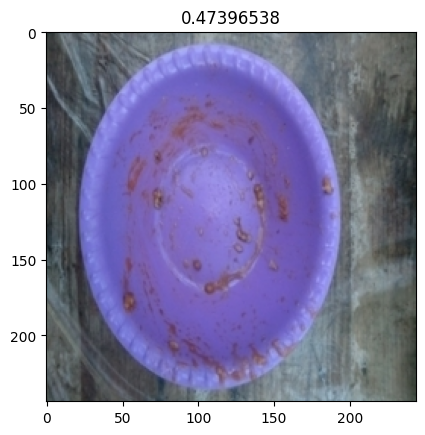

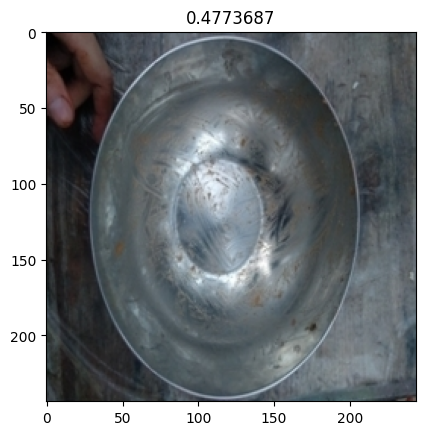

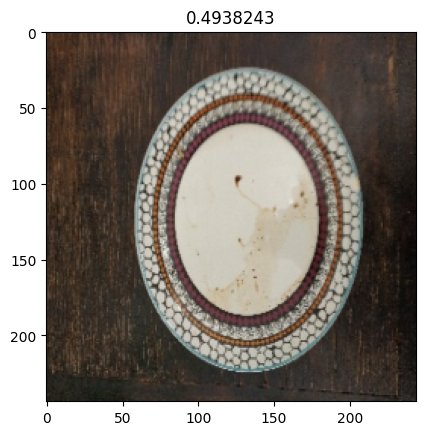

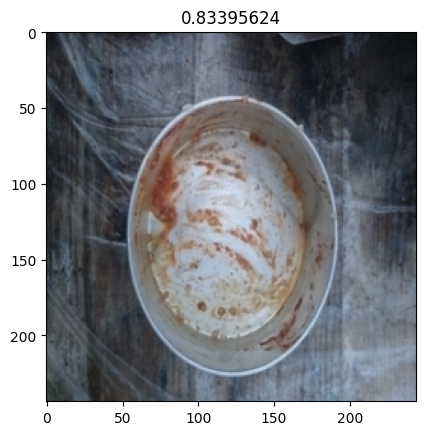

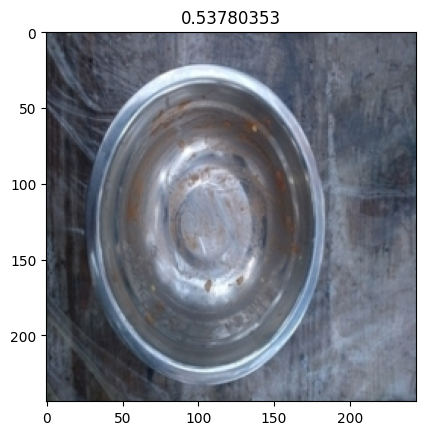

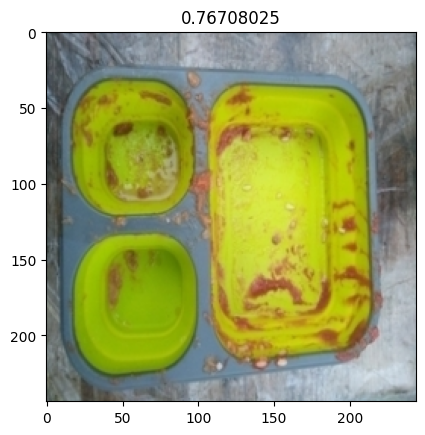

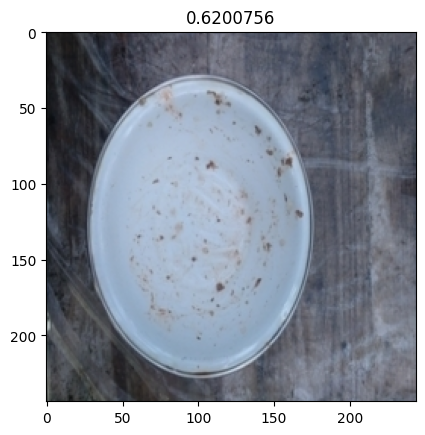

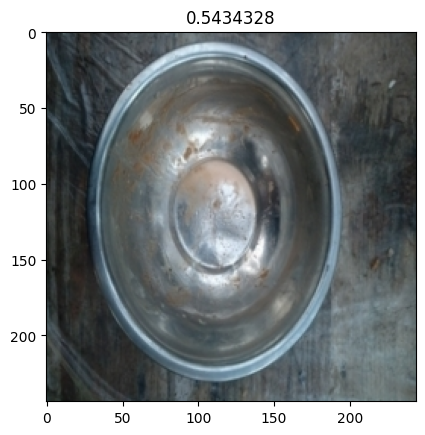

In [16]:
inputs , labels , paths = next(iter(test_dataloader)) 

for img , pred in zip(inputs , test_predictions): 
   input_photos(img , title = pred)

# 9. making a new data file

In [17]:
submission_df = pd.DataFrame.from_dict({'id':test_img_paths,'label':test_predictions})
submission_df['label'] = submission_df['label'].map(lambda pred: 'dirty' if pred > 0.5 else 'cleaned')
submission_df['id'] = submission_df['id'].str.replace('/kaggle/working/test/Nene!','') 
submission_df['id'] = submission_df['id'].str.replace('.jpg','') 
submission_df.set_index('id',inplace = True)
submission_df.head()

,label
id,
/0000,cleaned
/0001,cleaned
/0002,cleaned
/0003,dirty
/0004,dirty


In [18]:
submission_df.to_csv('submission.csv')